In [1]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
#import wandb

We always check that we are running on a GPU

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02514/

In [3]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='/dtu/datasets1/02514/hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [4]:
#size = 128
train_transform = transforms.Compose([transforms.Resize(256), 
                                      transforms.CenterCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomRotation(30),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                     ])
test_transform = transforms.Compose([transforms.Resize(256), 
                                     transforms.CenterCrop(224), 
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                    ])

batch_size = 64
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=3)

Let's look at some images from our data 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

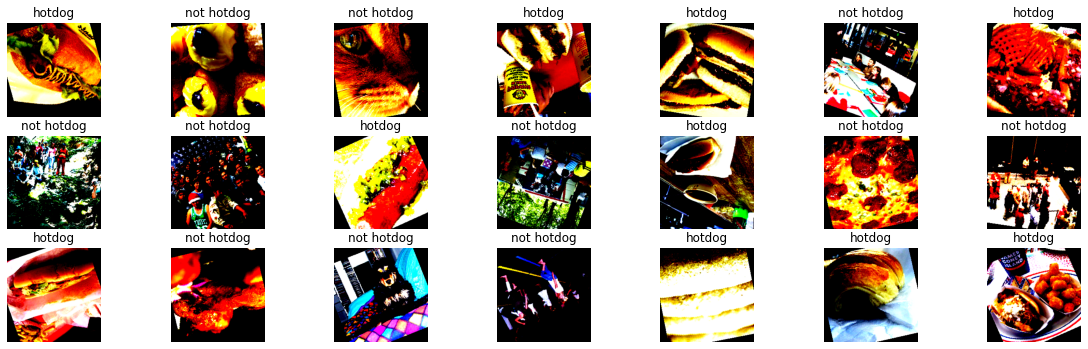

In [5]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')


Remember to save the state of your model AND optimizer regularly in case the Colab runtime times out.
You can save your model to your google drive, so you can get it from there in a new colab session. 

If you only save it in the colab notebook, there's no way to get it into a new session.

Now create a model and train it!


In [6]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs=10):
    def loss_fun(output, target):
        loss = nn.CrossEntropyLoss()
        return loss(output, target)
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
    patience = 0
  
    for epoch in tqdm(range(num_epochs), unit='epoch'):        
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = loss_fun(output, target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
        #Comput the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            test_loss.append(loss_fun(output, target).cpu().item())
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().cpu().item()
        out_dict['train_acc'].append(train_correct/len(trainset))
        out_dict['test_acc'].append(test_correct/len(testset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")
        
        wandb.log({"train_acc": out_dict['train_acc'][-1],
                  "test_acc": out_dict['test_acc'][-1],
                  "train_loss": out_dict['train_loss'][-1],
                   "test_loss": out_dict['test_loss'][-1]})      
        
        if out_dict['test_loss'][-1] > min(out_dict['test_loss']):
            patience += 1 
        else: 
            patience = 0
            
        if patience == 6:
            print("EARLY STOPPED!")
            break 
       
    return out_dict

In [7]:
model_SGD = models.resnet18(pretrained=False)
num_ftrs = model_SGD.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_SGD.fc = nn.Linear(num_ftrs, 2)

model_ADAM = models.resnet18(pretrained=False)
num_ftrs = model_ADAM.fc.in_features
model_ADAM.fc = nn.Linear(num_ftrs, 2)

model_pre_SGD = models.resnet18(pretrained=True)
num_ftrs = model_pre_SGD.fc.in_features
model_pre_SGD.fc = nn.Linear(num_ftrs, 2)

model_pre_ADAM = models.resnet18(pretrained=True)
num_ftrs = model_pre_ADAM.fc.in_features
model_pre_ADAM.fc = nn.Linear(num_ftrs, 2)

model_SGD.to(device)
model_ADAM.to(device)
model_pre_SGD.to(device)
model_pre_ADAM.to(device)

#Initialize the optimizer
SGD_lr = 0.001
ADAM_lr = 0.000005
optimizer_SGD = torch.optim.SGD(model_SGD.parameters(), lr=SGD_lr)
optimizer_ADAM = torch.optim.Adam(model_ADAM.parameters(),lr=ADAM_lr)

#Initialize the optimizer
pre_SGD_lr = 0.001
pre_ADAM_lr = 0.00001
optimizer_pre_SGD = torch.optim.SGD(model_pre_SGD.parameters(), lr=pre_SGD_lr)
optimizer_pre_ADAM = torch.optim.Adam(model_pre_ADAM.parameters(),lr=pre_ADAM_lr)

#scheduler_SGD = torch.optim.lr_scheduler.StepLR(optimizer_SGD, step_size=1, gamma=0.1)
#scheduler_ADAM = torch.optim.lr_scheduler.StepLR(optimizer_ADAM, step_size=1, gamma=0.1)
#scheduler_pre_SGD = torch.optim.lr_scheduler.StepLR(optimizer_pre_SGD, step_size=1, gamma=0.1)
#scheduler_pre_ADAM = torch.optim.lr_scheduler.StepLR(optimizer_pre_ADAM, step_size=1, gamma=0.1)

num_epoch = 50

wandb: Currently logged in as: gizemggungor. Use `wandb login --relogin` to force relogin


  0%|          | 0/50 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.696	 test: 0.685	 Accuracy train: 53.6%	 test: 54.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.664	 test: 0.669	 Accuracy train: 62.1%	 test: 57.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.647	 test: 0.657	 Accuracy train: 64.4%	 test: 59.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.635	 test: 0.662	 Accuracy train: 66.0%	 test: 59.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.621	 test: 0.633	 Accuracy train: 67.6%	 test: 64.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.611	 test: 0.629	 Accuracy train: 68.2%	 test: 65.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.599	 test: 0.621	 Accuracy train: 69.4%	 test: 65.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.591	 test: 0.612	 Accuracy train: 70.2%	 test: 66.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.582	 test: 0.608	 Accuracy train: 71.0%	 test: 67.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.571	 test: 0.614	 Accuracy train: 72.2%	 test: 67.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.568	 test: 0.601	 Accuracy train: 72.8%	 test: 68.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.564	 test: 0.592	 Accuracy train: 72.5%	 test: 70.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.557	 test: 0.600	 Accuracy train: 73.5%	 test: 69.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.552	 test: 0.577	 Accuracy train: 73.3%	 test: 70.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.545	 test: 0.582	 Accuracy train: 73.4%	 test: 70.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.538	 test: 0.587	 Accuracy train: 75.2%	 test: 70.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.534	 test: 0.582	 Accuracy train: 74.6%	 test: 70.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.530	 test: 0.588	 Accuracy train: 74.6%	 test: 71.5%
DECAY!


/zhome/ad/0/134360/venv_2/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.528	 test: 0.571	 Accuracy train: 74.6%	 test: 71.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.522	 test: 0.568	 Accuracy train: 75.7%	 test: 71.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.524	 test: 0.577	 Accuracy train: 76.0%	 test: 71.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.524	 test: 0.579	 Accuracy train: 75.8%	 test: 71.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.521	 test: 0.564	 Accuracy train: 75.8%	 test: 71.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.521	 test: 0.564	 Accuracy train: 76.5%	 test: 71.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.522	 test: 0.562	 Accuracy train: 75.6%	 test: 71.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.521	 test: 0.560	 Accuracy train: 76.6%	 test: 71.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.521	 test: 0.560	 Accuracy train: 75.7%	 test: 71.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.520	 test: 0.570	 Accuracy train: 75.5%	 test: 71.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.517	 test: 0.564	 Accuracy train: 76.4%	 test: 71.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.518	 test: 0.563	 Accuracy train: 75.7%	 test: 71.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.518	 test: 0.578	 Accuracy train: 76.0%	 test: 71.4%
DECAY!


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.515	 test: 0.567	 Accuracy train: 75.7%	 test: 71.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.520	 test: 0.566	 Accuracy train: 75.5%	 test: 72.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.513	 test: 0.567	 Accuracy train: 76.4%	 test: 72.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.525	 test: 0.563	 Accuracy train: 75.6%	 test: 71.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.516	 test: 0.555	 Accuracy train: 76.7%	 test: 71.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.515	 test: 0.558	 Accuracy train: 76.1%	 test: 72.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.515	 test: 0.571	 Accuracy train: 76.5%	 test: 71.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.515	 test: 0.553	 Accuracy train: 76.1%	 test: 71.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.514	 test: 0.561	 Accuracy train: 76.7%	 test: 71.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.516	 test: 0.571	 Accuracy train: 76.3%	 test: 72.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.520	 test: 0.556	 Accuracy train: 76.2%	 test: 71.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.519	 test: 0.559	 Accuracy train: 76.1%	 test: 71.6%
DECAY!


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.516	 test: 0.567	 Accuracy train: 76.3%	 test: 72.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.518	 test: 0.570	 Accuracy train: 76.1%	 test: 71.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.514	 test: 0.578	 Accuracy train: 76.3%	 test: 71.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.519	 test: 0.564	 Accuracy train: 76.6%	 test: 72.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.517	 test: 0.563	 Accuracy train: 76.6%	 test: 71.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.515	 test: 0.574	 Accuracy train: 75.8%	 test: 71.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.520	 test: 0.569	 Accuracy train: 75.6%	 test: 71.8%


test_acc,▁▂▃▃▅▅▆▆▇▇▇▇▇▇██████████████████████████
test_loss,█▇▇▇▅▅▄▄▄▃▃▂▃▂▃▂▂▂▂▂▁▁▂▂▂▂▂▂▁▁▂▁▂▁▁▂▂▂▁▂
train_acc,▁▄▄▅▅▆▆▆▇▇▇▇█▇▇▇████████████████████████
train_loss,█▇▆▆▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,0.71805
test_loss,0.56944
train_acc,0.75574
train_loss,0.51988


  0%|          | 0/50 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.693	 test: 0.698	 Accuracy train: 51.3%	 test: 48.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.695	 test: 0.695	 Accuracy train: 50.4%	 test: 50.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.695	 test: 0.696	 Accuracy train: 49.7%	 test: 50.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.695	 test: 0.696	 Accuracy train: 49.1%	 test: 50.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.693	 test: 0.697	 Accuracy train: 50.5%	 test: 50.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.691	 test: 0.697	 Accuracy train: 51.9%	 test: 50.4%
DECAY!


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.692	 test: 0.697	 Accuracy train: 50.8%	 test: 50.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.692	 test: 0.697	 Accuracy train: 51.7%	 test: 50.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.692	 test: 0.694	 Accuracy train: 52.8%	 test: 50.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.693	 test: 0.695	 Accuracy train: 51.5%	 test: 50.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.693	 test: 0.696	 Accuracy train: 50.1%	 test: 50.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.693	 test: 0.694	 Accuracy train: 51.1%	 test: 50.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.692	 test: 0.696	 Accuracy train: 50.2%	 test: 50.5%
DECAY!


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.691	 test: 0.697	 Accuracy train: 52.1%	 test: 50.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.694	 test: 0.695	 Accuracy train: 49.0%	 test: 50.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.692	 test: 0.696	 Accuracy train: 50.4%	 test: 50.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.693	 test: 0.695	 Accuracy train: 51.2%	 test: 50.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.692	 test: 0.695	 Accuracy train: 52.4%	 test: 50.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.693	 test: 0.697	 Accuracy train: 51.6%	 test: 50.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.692	 test: 0.696	 Accuracy train: 51.4%	 test: 50.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.695	 test: 0.695	 Accuracy train: 50.6%	 test: 50.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.693	 test: 0.695	 Accuracy train: 50.5%	 test: 51.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.693	 test: 0.695	 Accuracy train: 50.2%	 test: 50.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.694	 test: 0.696	 Accuracy train: 50.2%	 test: 50.6%


  0%|          | 0/32 [00:00<?, ?it/s]

KeyboardInterrupt: 

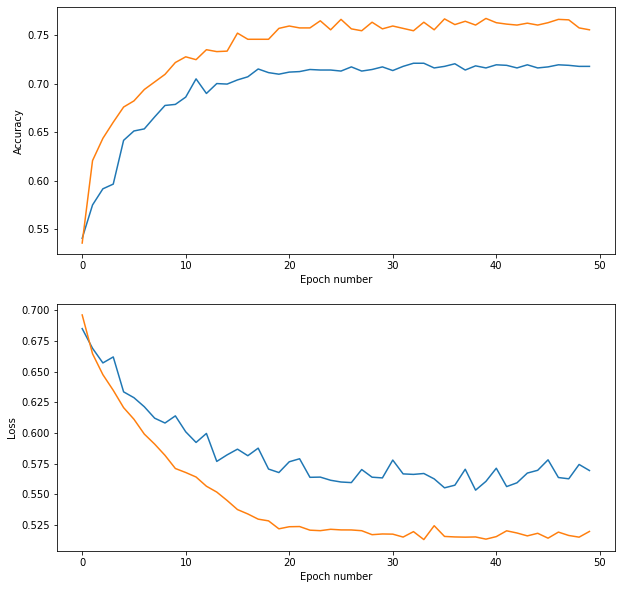

In [8]:
#wandb.init(project="Hotdog2", name="ResNet_SGD", entity="gizemggungor")
#wandb.config.update({
#  "learning_rate": SGD_lr,
#  "epochs": num_epoch,
#  "optimizer" : "SGD",
#  "predefined" : False,
#  "data_augmentation" : True,  
#  "stepLR" : True  
#})

out_dict = train(model_SGD, optimizer_SGD, num_epoch)
fig, ax = plt.subplots(2,1,figsize=(10, 10))
ax[0].plot(out_dict["test_acc"], label='SGD Test Acc')
ax[0].plot(out_dict["train_acc"], label='SGD Train Acc')
ax[0].set_xlabel('Epoch number')
ax[0].set_ylabel('Accuracy')


ax[1].plot(out_dict["test_loss"], label='SGD Test Loss')
ax[1].plot(out_dict["train_loss"], label='SGD Train Loss')
ax[1].set_xlabel('Epoch number')
ax[1].set_ylabel('Loss')

#wandb.init(project="Hotdog2", name="ResNet_ADAM", entity="gizemggungor")
#wandb.config.update({
#  "learning_rate": ADAM_lr,
#  "epochs": num_epoch,
#  "optimizer" : "ADAM",
#  "predefined" : False,
#  "data_augmentation" : True,
#  "stepLR" : True
#})
out_dict = train(model_ADAM, optimizer_ADAM, num_epoch)
ax[0].plot(out_dict["test_acc"], label='ADAM Test Acc')
ax[0].plot(out_dict["train_acc"], label='ADAM Train Acc')
ax[0].set_xlabel('Epoch number')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(out_dict["test_loss"], label='ADAM Test Loss')
ax[1].plot(out_dict["train_loss"], label='ADAM Train Loss')
ax[1].set_xlabel('Epoch number')
ax[1].set_ylabel('Loss')
ax[1].legend()

In [ ]:
#wandb.init(project="Hotdog2", name="ResNet_pre_SGD", entity="gizemggungor")
#wandb.config.update({
#  "learning_rate": pre_SGD_lr,
#  "epochs": num_epoch,
#  "optimizer" : "SGD",
#  "predefined" : True,
#  "data_augmentation" : True,
#  "stepLR" : True
#})

out_dict = train(model_pre_SGD, optimizer_pre_SGD, num_epoch)
fig, ax = plt.subplots(2,1,figsize=(10, 10))
ax[0].plot(out_dict["test_acc"], label='SGD Test Acc')
ax[0].plot(out_dict["train_acc"], label='SGD Train Acc')
ax[0].set_xlabel('Epoch number')
ax[0].set_ylabel('Accuracy')


ax[1].plot(out_dict["test_loss"], label='SGD Test Loss')
ax[1].plot(out_dict["train_loss"], label='SGD Train Loss')
ax[1].set_xlabel('Epoch number')
ax[1].set_ylabel('Loss')

#wandb.init(project="Hotdog2", name="ResNet_pre_ADAM", entity="gizemggungor")
#wandb.config.update({
#  "learning_rate": pre_ADAM_lr,
#  "epochs": num_epoch,
#  "optimizer" : "ADAM",
#  "predefined" : True,
#  "data_augmentation" : True,
#  "stepLR" : True
#})
out_dict = train(model_pre_ADAM, optimizer_pre_ADAM, num_epoch)
ax[0].plot(out_dict["test_acc"], label='ADAM Test Acc')
ax[0].plot(out_dict["train_acc"], label='ADAM Train Acc')
ax[0].set_xlabel('Epoch number')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(out_dict["test_loss"], label='ADAM Test Loss')
ax[1].plot(out_dict["train_loss"], label='ADAM Train Loss')
ax[1].set_xlabel('Epoch number')
ax[1].set_ylabel('Loss')
ax[1].legend()

In [ ]:
#salicancy map

def m_c_hat(x,N,std=0.3):
    smooth = 0
    std /= torch.max(x) - torch.min(x)
    for i in range(N):
        smooth  =+ m_c(x + (torch.randn(x.size()) * std))
    return smooth / N

def m_c(x):
    x = x.to(device)
    x.requires_grad_()
    scores = model_pre_ADAM(x)

    # Get the index corresponding to the maximum score and the maximum score itself.
    score_max_index = scores.argmax()
    score_max = scores[0, score_max_index]

    score_max.backward()
    
    saliency, _ = torch.max(x.grad.data.abs(), dim=1) 
    return saliency

In [ ]:
images, labels = next(iter(test_loader))

model = model_pre_ADAM
model.to(device)
model.eval()

X = images[0,:,:,:]
X = X[None,:,:,:]

saliency = m_c(X)

# code to plot the saliency map as a heatmap
plt.imshow(saliency[0].cpu(), cmap=plt.cm.hot)
plt.axis('off')
plt.show()


In [ ]:

fig, axs = plt.subplots(2,7,figsize=(20,10))


images, labels = next(iter(test_loader))

model.to('cuda')
model.eval()

stds = [0.08,0.09,0.1,0.11,0.12,0.13,0.14]

for i in range(7):
    imgid = 11+i
    X = images[imgid,:,:,:]
    X = X[None,:,:,:]

    saliency = m_c_hat(X,7, 0.1)
    #saliency = m_c(X)
    
    axs[0,i].imshow(np.swapaxes(np.swapaxes(images[imgid].numpy(), 0, 2), 0, 1))
    axs[0,i].title.set_text(['hotdog', 'not hotdog'][labels[imgid].item()])
    #axs[0,i].title.set_text(stds[i])
    axs[1,i].axis('off')
    axs[0,i].axis('off')
    axs[1,i].imshow(saliency[0].cpu(), cmap=plt.cm.hot)
#     axs[1,i].imshow(saliency[0])


In [ ]:
torch.save(model_pre_ADAM.state_dict(), "ResNet_pre_Adam.pt")
torch.save(model_pre_SGD.state_dict(), "ResNet_pre_SGD.pt")